In [27]:
import pandas as pd
from utils import ftextraction
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import Imputer
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from utils import plotting
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import copy
import gc
gc.enable()
%matplotlib inline

In [110]:
vs = plotting.Visualizations()
fe = ftextraction.Extractor()

##### Preprocess datasets 

In [ ]:
#load datasets
start = time.time()
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
buro = pd.read_csv('data/bureau.csv')
bb = pd.read_csv('data/bureau_balance.csv')
ccb = pd.read_csv('data/credit_card_balance.csv')
ipay = pd.read_csv('data/installments_payments.csv')
pos = pd.read_csv('data/POS_CASH_balance.csv')
pa = pd.read_csv('data/previous_application.csv')
end = time.time()
print('Datasets loaded in: {:.2f} minutes'.format((end-start)/60))

In [ ]:
#process datasets
start = time.time()
# data = fe.process_datasets(app_train,app_test,buro,bb,pa,ipay,ccb,pos,fe=False,path='processed/alldata.csv')
data_fe = fe.process_datasets(app_train,app_test,buro,bb,pa,ipay,ccb,pos,path='processed/alldata_fe.csv')
end = time.time()
print('Datasets processed in: {:.2f} minutes'.format((end-start)/60))

In [111]:
data = pd.read_csv('processed/alldata.csv')
# data_fe = pd.read_csv('processed/alldata_fe.csv')

### BASELINE MODELS 

#### TRAINING PIPELINE

In [136]:
def baseline_modelling(model,data):
       
    #preprocessing data    
    train = data.loc[data['TARGET'].notnull(),:].copy()
    test = data.loc[data['TARGET'].isnull(),:].copy()
    del data
    gc.collect()
    # save test IDs for final submission dataframe
    test_IDs = test['SK_ID_CURR']
    # save target labels
    labels = train['TARGET']
    # drop ID columns
    train = train.drop(columns=['SK_ID_CURR','TARGET'])
    test = test.drop(columns=['SK_ID_CURR'])

    #drop features with a high number of missing values:
    train = fe.drop_missing_values(train,20)
    test = fe.drop_missing_values(test,20)
    
    # aligining dataframes
    train,test = train.align(test,join='inner',axis=1)

    # Impute training and testing data
    
    imputer = Imputer(strategy='mean')
    imputer.fit(train)
    train = imputer.transform(train)
    test = imputer.transform(test)

    # converting to numpy array for lgbm consumptions
    train = np.array(train)
    test = np.array(test)

    #DATA STRUCTURES TO STORE PREDICTIONS AND METRICS

    #store cv predictions
    oof_predictions = np.zeros(train.shape[0])
    #store predictions on test dataset
    test_preds = np.zeros(test.shape[0])
    #store predictions on train dataset
    train_preds = np.zeros(train.shape[0])
    #store scores
    scores = {}

    #SPLITTING AND TRAINING 
    kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=40)
    fold = 1
    start = time.time()
    print('Training started')
    for train_i,valid_i in kfold.split(train,labels):
        xtrain,ytrain = train[train_i],labels[train_i]
        xvalid,yvalid = train[valid_i],labels[valid_i]
        
        #classifier object
        classifier = copy.copy(model)
        # fitting on the training set
        classifier.fit(xtrain,ytrain)
 
        # storing out of fold predictions:
        oof_predictions[valid_i] = classifier.predict_proba(xvalid)[:, 1]

        # storing test set predictions:
        test_preds += classifier.predict_proba(test)[:, 1] /kfold.n_splits

        #storing training set predictions
        train_preds[train_i] = classifier.predict_proba(xtrain)[:, 1]
        
        #false and true positive rates for plotting roc curve
        fpr,tpr,threshold = roc_curve(yvalid,oof_predictions[valid_i])
        print('Fold %d done.'%fold)
        fold += 1
        # freeing up memory
        del xtrain,ytrain,xvalid,yvalid,classifier
        gc.collect()
        
    end = time.time()    
    print('Training done in {:.2f} minutes'.format((end-start)/60))    
    #SCORES
    
    training_score = roc_auc_score(labels,train_preds)
    cv = roc_auc_score(labels,oof_predictions)
    
    fpr,tpr,threshold = roc_curve(labels,oof_predictions)
    
    scores['training score'] = [training_score]
    scores['cv score'] = [cv]
    scores = pd.DataFrame.from_dict(scores)
    print('Overall CV Score: %.4f' %cv)
    # submission dataframe:
    submission = pd.DataFrame({'SK_ID_CURR': test_IDs, 'TARGET': test_preds})

    return submission, scores,fpr,tpr

In [ ]:
#Baseline models
rf = RandomForestClassifier()
lr = LogisticRegression()
xgb = XGBClassifier()
classifiers = [rf,lr,xgb]
model_scores = []
model_predictions = []
model_fprs = []
model_tprs = []

for classifier in classifiers:
    print(f'Training {classifier.__class__.__name__} model')
    submission,scores,fpr,tpr = baseline_modelling(classifier,data)
    model_scores.append(scores)
    model_predictions.append(submission)
    model_fprs.append(fpr)
    model_tprs.append(tpr)
    print('Training complete')

In [41]:
#model scores
clf_names = ['Random Forest','Logistic Regression','XGBoost']
all_scores = pd.concat(model_scores)
all_scores.index = clf_names

In [80]:
all_scores

,training score,cv score
Random Forest,0.999753,0.629552
Logistic Regression,0.635356,0.633084
XGBoost,0.778391,0.765616


In [ ]:
model_predictions[2].to_csv('submissions/xgb_baseline.csv',index=False)

#### ROC Curves

In [ ]:
fig = plt.figure(figsize=(6,5))
for i in range(len(model_fprs)):
    base_roc = auc(model_fprs[i],model_tprs[i])
    plt.plot(model_fprs[i],model_tprs[i],label='{} ROC: {:.4f}'.format(clf_names[i],base_roc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Naive', alpha=0.5)
plt.title('ROC Curves for Baseline Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.show()
plt.savefig('baseline_roc.png',bbox_inches='tight')

### SOLUTION MODEL 

In [19]:
def model(data,folds,iterations,exclude=[]):
       
    #preprocessing data    
    train = data.loc[data['TARGET'].notnull(),:].copy()
    test = data.loc[data['TARGET'].isnull(),:].copy()
    del data
    gc.collect()

    # save test IDs for final submission dataframe
    test_IDs = test['SK_ID_CURR']
    # save target labels
    labels = train['TARGET']
    # drop ID columns
    train = train.drop(columns=['SK_ID_CURR','TARGET'])
    test = test.drop(columns=['SK_ID_CURR'])


    # drop features with no importance
    train.drop(columns=exclude,inplace=True)
    test.drop(columns=exclude,inplace=True)

    # aligining dataframes
    train,test = train.align(test,join='inner',axis=1)

    # for storing feature importances
    features = list(train.columns)
    ft_importances = np.zeros(len(features))

    # converting to numpy array for lgbm consumptions
    train = np.array(train)
    test = np.array(test)

    #DATA STRUCTURES TO STORE PREDICTIONS AND METRICS

    #store cv predictions
    oof_predictions = np.zeros(train.shape[0])
    oof_predabs = np.zeros(train.shape[0])

    #store predictions on test dataset
    test_preds = np.zeros(test.shape[0])
    #store predictions on train dataset
    train_preds = np.zeros(train.shape[0])
    #store scores
    scores = {}

    #SPLITTING AND TRAINING 
    kfold = StratifiedKFold(n_splits=folds,shuffle=True,random_state=40)
    fold = 1
    start = time.time()
    fprs = {}
    tprs = {}
    aucs = []
    models = []
    print('Training started')
    for train_i,valid_i in kfold.split(train,labels):
        xtrain,ytrain = train[train_i],labels[train_i]
        xvalid,yvalid = train[valid_i],labels[valid_i]
    
        # creating the classifier 
        clf = lgbm.LGBMClassifier(boosting_type='gbdt',num_leaves=40,
                                 learning_rate=0.02,reg_alpha=1,
                                 min_child_samples=45,reg_lambda=0.142857,
                                 colsample_bytree=0.5,subsample=0.915152,
                                 is_unbalance=True,
                                 n_estimators=10000,random_state=50)

        # fitting on the training set
        clf.fit(xtrain,ytrain,eval_set=[(xtrain, ytrain), (xvalid, yvalid)],eval_metric ='auc',
                 verbose =200,early_stopping_rounds= iterations,eval_names = ['train','valid'])

        #best iteration
        best_iter = clf.best_iteration_
        
        # storing out of fold predictions:
        oof_predictions[valid_i] = clf.predict_proba(xvalid,num_iteration=best_iter)[:, 1]
        oof_predabs[valid_i] = clf.predict(xvalid,num_iteration=best_iter)

        # storing test set predictions:
        test_preds += clf.predict_proba(test,num_iteration=best_iter)[:, 1] /kfold.n_splits

        #stortin training set predictions
        train_preds[train_i] = clf.predict_proba(xtrain,num_iteration=best_iter)[:, 1]

        # storing feature importances            
        ft_importances += clf.feature_importances_ /kfold.n_splits
        
        #false and true positive rates for plotting roc curve
        fpr,tpr,threshold = roc_curve(yvalid,oof_predictions[valid_i])
        fprs[f'fold_{fold}'] = fpr
        tprs[f'fold_{fold}'] = tpr
        rauc_scr = auc(fpr,tpr)
        aucs.append(rauc_scr)
        print('Fold %d done.'%fold)
        fold += 1
        #store model
        models.append(clf)
        # freeing up memory
        del xtrain,ytrain,xvalid,yvalid,clf
        gc.collect()
        
    end = time.time()    
    print('Training done in {:.2f} minutes'.format((end-start)/60))    
    #SCORES

    feature_importances = pd.DataFrame({'features':features,'importance':ft_importances})
    
    training_score = roc_auc_score(labels,train_preds)
    cv = roc_auc_score(labels,oof_predictions)
    
    fpr,tpr,threshold = roc_curve(labels,oof_predictions)
    fprs['OCV'] = fpr
    tprs['OCV'] = tpr
    aucs.append(cv) 
    
    scores['training score'] = [training_score]
    scores['cv score'] = [cv]
    scores = pd.DataFrame.from_dict(scores)
    print('Overall CV Score: %.4f' %cv)
    # submission dataframe:
    submission = pd.DataFrame({'SK_ID_CURR': test_IDs, 'TARGET': test_preds})

    return models,submission, scores, oof_predabs, feature_importances,fprs,tprs,aucs

In [20]:
#feature selection from previous runs
fi = pd.read_csv('fi_lgbm_V0_fe.csv')
no_imp=list(fi.loc[fi['importance']==0,'features'])

In [ ]:
mdls,fsubmission, fscores, oof_predabs, fi_final,ffprs,ftprs,faucs = model(data_fe,10,100,exclude=no_imp)

##### Model Details

In [23]:
#classification report
print(classification_report(data_fe.loc[data_fe['TARGET'].notnull(),'TARGET'],oof_predabs))

             precision    recall  f1-score   support

        0.0       0.96      0.76      0.85    282686
        1.0       0.20      0.68      0.30     24825

avg / total       0.90      0.75      0.80    307511



In [24]:
print(confusion_matrix(data_fe.loc[data_fe['TARGET'].notnull(),'TARGET'],oof_predabs))

[[213470  69216]
 [  7932  16893]]


##### ROC Curve over Folds

In [118]:
folds_no = list(ffprs.keys())

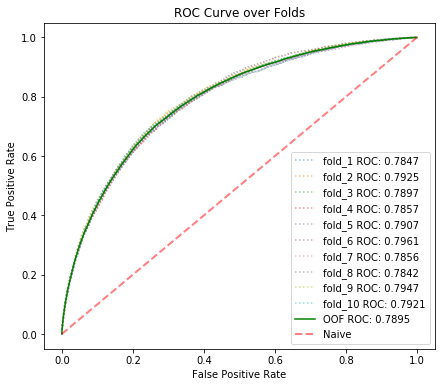

In [135]:
fig = plt.figure(figsize=(7,6))

for i in range(len(folds_no)-1):
    foldscore = auc(ffprs[folds_no[i]],ftprs[folds_no[i]])
    plt.plot(ffprs[folds_no[i]],ftprs[folds_no[i]],
            label='{} ROC: {:.4f}'.format(folds_no[i],foldscore),alpha=0.5,linestyle=':')

lgbm_roc = auc(ffprs['OCV'],ftprs['OCV'])
plt.plot(ffprs['OCV'],ftprs['OCV'],label='{} ROC: {:.4f}'.format('OOF',lgbm_roc),color='g')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Naive', alpha=0.5)
plt.title('ROC Curve over Folds')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.show()
plt.savefig('solution_roc_folds.png',bbox_inches='tight')

##### ROC Curves against Baseline

In [137]:
xgb = XGBClassifier()

In [138]:
xubmission, scores,xfpr,xtpr = baseline_modelling(xgb,data)

Dropping 483 columns....
Dropping 415 columns....
Training started
Fold 1 done.
Fold 2 done.
Fold 3 done.
Training done in 42.56 minutes
Overall CV Score: 0.7656


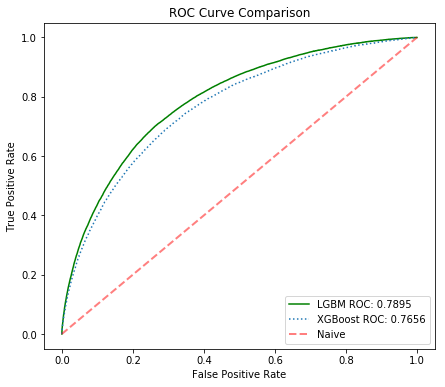

In [143]:
fig = plt.figure(figsize=(7,6))
lgbm_roc = auc(ffprs['OCV'],ftprs['OCV'])
xgb_roc = auc(xfpr,xtpr)
plt.plot(ffprs['OCV'],ftprs['OCV'],label='LGBM ROC: {:.4f}'.format(lgbm_roc),color='g')
plt.plot(xfpr,xtpr,label='XGBoost ROC: {:.4f}'.format(xgb_roc), linestyle=':')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Naive', alpha=0.5)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.show()
plt.savefig('solution_vs_base.png',bbox_inches='tight')

Including hyperparameters

In [ ]:
params = {'boosting_type':'gbdt','num_leaves':40,
           'learning_rate':0.02,'min_child_samples':45,
           'reg_alpha':1,'reg_lambda':0.142857,
           'colsample_bytree':0.5,'subsample':0.915152,
           'is_unbalance':True,'n_estimators':10000}

In [ ]:
def lgbmV1(data,folds,params,iterations,exclude=[]):
       
    #preprocessing data    
    train = data.loc[data['TARGET'].notnull(),:].copy()
    test = data.loc[data['TARGET'].isnull(),:].copy()
    del data
    gc.collect()

    # save test IDs for final submission dataframe
    test_IDs = test['SK_ID_CURR']
    # save target labels
    labels = train['TARGET']
    # drop ID columns
    train = train.drop(columns=['SK_ID_CURR','TARGET'])
    test = test.drop(columns=['SK_ID_CURR'])


    # drop features with no importance
    train.drop(columns=exclude,inplace=True)
    test.drop(columns=exclude,inplace=True)

    # aligining dataframes
    train,test = train.align(test,join='inner',axis=1)

    # for storing feature importances
    features = list(train.columns)
    ft_importances = np.zeros(len(features))

    # converting to numpy array for lgbm consumptions
    train = np.array(train)
    test = np.array(test)

    #DATA STRUCTURES TO STORE PREDICTIONS AND METRICS

    #store cv predictions
    oof_predictions = np.zeros(train.shape[0])
    #store predictions on test dataset
    test_preds = np.zeros(test.shape[0])
    #store predictions on train dataset
    train_preds = np.zeros(train.shape[0])
    #store scores
    scores = {}

    #SPLITTING AND TRAINING 
    kfold = StratifiedKFold(n_splits=folds,shuffle=True,random_state=40)
    fold = 1
    start = time.time()
    fprs = {}
    tprs = {}
    aucs = []
    models = []
    print('Training started')
    for train_i,valid_i in kfold.split(train,labels):
        xtrain,ytrain = train[train_i],labels[train_i]
        xvalid,yvalid = train[valid_i],labels[valid_i]
        
        # creating the classifier 
        clf = lgbm.LGBMClassifier(boosting_type=params['boosting_type'],num_leaves=params['num_leaves'],
                                 learning_rate=params['learning_rate'],reg_alpha=params['reg_alpha'],
                                 min_child_samples=params['min_child_samples'],reg_lambda=params['reg_lambda'],
                                 colsample_bytree=params['colsample_bytree'],subsample=params['subsample'],
                                 is_unbalance=params['is_unbalance'],
                                 n_estimators=params['n_estimators'])

        # fitting on the training set
        clf.fit(xtrain,ytrain,eval_set=[(xtrain, ytrain), (xvalid, yvalid)],eval_metric ='auc',
                verbose= 200, early_stopping_rounds= iterations,eval_names = ['train','valid'])

        #best iteration
        best_iter = clf.best_iteration_
        
        # storing out of fold predictions:
        oof_predictions[valid_i] = clf.predict_proba(xvalid,num_iteration=best_iter)[:, 1]

        # storing test set predictions:
        test_preds += clf.predict_proba(test,num_iteration=best_iter)[:, 1] /kfold.n_splits

        #stortin training set predictions
        train_preds[train_i] = clf.predict_proba(xtrain,num_iteration=best_iter)[:, 1]

        # storing feature importances            
        ft_importances += clf.feature_importances_ /kfold.n_splits
        
        #false and true positive rates for plotting roc curve
        fpr,tpr,threshold = roc_curve(yvalid,oof_predictions[valid_i])
        fprs[f'fold_{fold}'] = fpr
        tprs[f'fold_{fold}'] = tpr
        rauc_scr = auc(fpr,tpr)
        aucs.append(rauc_scr)
        print('Fold %d done.'%fold)
        fold += 1
        #store model
        models.append(clf)
        # freeing up memory
        del xtrain,ytrain,xvalid,yvalid,clf
        gc.collect()
        
    end = time.time()    
    print('Training done in {:.2f} minutes'.format((end-start)/60))    
    #SCORES

    feature_importances = pd.DataFrame({'features':features,'importance':ft_importances})
    
    training_score = roc_auc_score(labels,train_preds)
    cv = roc_auc_score(labels,oof_predictions)
    
    fpr,tpr,threshold = roc_curve(labels,oof_predictions)
    fprs['OCV'] = fpr
    tprs['OCV'] = tpr
    aucs.append(cv) 
    
    scores['training score'] = [training_score]
    scores['cv score'] = [cv]
    scores = pd.DataFrame.from_dict(scores)
    print('Overall CV Score: %.4f' %cv)
    # submission dataframe:
    submission = pd.DataFrame({'SK_ID_CURR': test_IDs, 'TARGET': test_preds})

    return models,submission, scores, feature_importances,fprs,tprs,aucs

In [ ]:
submission_lgbmV1, scores_lgbmV1, fi_lgbm_V1,sfprs,stprs,saucs = lgbmV1(data_fe,5,params)

In [ ]:
submission_lgbmV1.to_csv('submission_lgbmV1.csv',index=False)

Modelling without no-importance features:

In [ ]:
fi = pd.read_csv('fi_lgbm_V0_fe.csv')
to_drop=list(fi.loc[fi['importance']==0,'features'])

In [ ]:
submission_lgbmV1_s, scores_lgbmV1_s, fi_lgbm_V1_s,fprs,tprs,aucs = lgbmV1(data_fe,5,params,exclude=to_drop)

In [ ]:
submission_lgbmV1_s.to_csv('submission_lgbmV1_s.csv',index=False)

##### Plotting ROC Curve

In [ ]:
fig = plt.figure(figsize=(6,5))
all_folds = list(fprs.keys())
for i in range(5):
    fold = all_folds[i]
    plt.plot(fprs[fold],tprs[fold]
         ,alpha=0.3,label='{} ROC AUC:{:.4f}'.format(fold,aucs[i]))

plt.plot(fprs['OCV'], tprs['OCV'],
         label='Mean ROC AUC:{:.4f}'.format(aucs[-1]),color='g')

plt.plot(fpr, tpr,
         label='Baseline: {:.4f}'.format(base_roc),color='c')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Naive', alpha=0.5)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model, submission_final, scores_final, fi_final,ffprs,ftprs,faucs = lgbmV1(data_fe,5,params,100,exclude=to_drop)

In [ ]:
model[-1].get_params()

##### Sensitivity Analysis 

In [100]:
#sort feature importance
fi = pd.read_csv('fi_lgbm_V0_fe.csv')
fi.sort_values('importance',ascending=False,inplace=True)
fi.reset_index(inplace=True,drop =True)
#keep features accouting for only 90% of importnace
fi['fi_cumsum'] = fi['importance'].cumsum()
#exclude features beyond 90% importance
drop_10 = list(fi.loc[fi['fi_cumsum']>0.9*fi['importance'].sum(),'features'])

Modelling with 90% importance:

In [ ]:
mdls90,fsubmission90, fscores90, oof_predabs90, fi_final90,ffprs90,ftprs90,faucs90 = model(data_fe,10,100,exclude=drop_10)

In [102]:
fsubmission90.to_csv('submissions/sublgbm90.csv',index=False)

Modelling without top 3 important features:

In [104]:
drop_top3 = list(fi.loc[:2,'features'])

In [ ]:
mdls3,fsubmission3, fscores3, oof_predabs3, fi_final3,ffprs3,ftprs3,faucs3 = model(data_fe,10,100,exclude=drop_top3)

In [106]:
fsubmission3.to_csv('submissions/fsubmission3.csv',index=False)